In [5]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import scienceplots             # needed for 'science' style

# ensure inline rendering matches saved figure / uncomment for larger inline figures
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

DATA_DIR = Path("results")
FIG_DIR  = Path("figures")

# physical constants
GC_VAL_4X4 = 2.54
GC_VAL_3X3 = 2.22
GC_LABEL   = r"Critical Point $g_c$"
SUPPORT_LABEL_T = r"Support $g$"

# layout defaults
SINGLE_COL_WIDTH = 3.5
DOUBLE_COL_WIDTH = 7.16
DPI = 150       # dpi is irrelevant for our vectorized output files

# fixed z-order levels
Z_PATCH = -1  # background color
Z_BG    = 0   # support guides
Z_CRIT  = 1   # critical point line
Z_REF   = 2   # ED Reference lines
Z_DATA  = 3   # main data markers/lines

# global plot styling using scienceplots
plt.style.use(["science", "ieee"])
plt.rcParams.update({"mathtext.fontset": "cm", "text.usetex": False})

# hardcoded seaborn-colorblind palette
SB_COLORBLIND = [
    "#0173b2", "#de8f05", "#029e73", "#d55e00", "#cc78bc",
    "#ca9161", "#fbafe4", "#949494", "#ece133", "#56b4e9",
]

# shared styles across figures
STYLE_REF = {"linestyle": "--", "color": "black", "alpha": 0.7, "linewidth": 1.0}
STYLE_SUPP = { "linestyle": (0, (1.5, 2.8)), "linewidth": 0.75, "color": "0.20", "alpha": 0.30}
STYLE_CRIT = { "linestyle": ":", "linewidth": 1.1, "color": "indianred"}

# filter 'alpha' for legend handles so icons are opaque
STYLE_LEGEND = {k: v for k, v in STYLE_SUPP.items() if k != 'alpha'}

STYLE_MARKER_BASE = {
    "support": {"marker": "o", "edge_w": 0.0},
    "novel":   {"marker": "D", "edge_w": 1.2},
}

# vertical lines in the backdrop
def draw_backdrop(ax, support_values, crit_val):
    ax.patch.set_zorder(Z_PATCH)

    for g in sorted(support_values):
        ax.axvline(g, zorder=Z_BG, **STYLE_SUPP)

    ax.axvline(crit_val, zorder=Z_CRIT, **STYLE_CRIT)

In [6]:
CSV_PATH = DATA_DIR / "tfim_4x4_sample_eff_rbm_err_20260123_112349.csv"
wide = pd.read_csv(CSV_PATH)

# pick only the value columns overlap_<n> (exclude *_err)
overlap_cols = sorted(
    [c for c in wide.columns if c.startswith("overlap_") and not c.endswith("_err")],
    key=lambda c: int(c.split("_", 1)[1]),
)

f1_data = []
f1_support_g = set()

for col in overlap_cols:
    n = int(col.split("_", 1)[1])
    err_col = f"{col}_err"

    use_cols = ["h", "type", col]
    rename = {col: "overlap"}

    if err_col in wide.columns:
        use_cols.append(err_col)
        rename[err_col] = "overlap_err"

    df = wide[use_cols].rename(columns=rename).copy()

    supp = df[df["type"] == "support"]
    nov  = df[df["type"] == "novel"]

    f1_support_g.update(supp["h"].values)
    f1_data.append(
        {
            "n_samples": n,
            "df": df,
            "supp": supp,
            "nov": nov,
            "has_err": ("overlap_err" in df.columns),
        }
    )

f1_support_g = sorted(f1_support_g)
print(f"Fig 1 data: {len(f1_data)} experiments loaded.")

Fig 1 data: 3 experiments loaded.


Saved: tfim_4x4_data_scaling.pdf


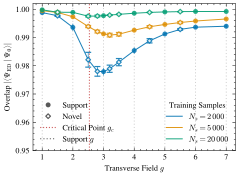

In [7]:
FIG_NAME = "tfim_4x4_data_scaling.pdf"

# local styling overrides
SIZE_SUPP   = 5.0
SIZE_NOV    = 3.3
LEGEND_GREY = "0.35"
YLIM        = (0.95, 1.002)
LINE_ALPHA  = 0.9

# errorbar styling (vanilla knobs)
ERR = dict(
    elinewidth=0.7,
    capsize=3,
    capthick=0.7,
    alpha=0.85,
)

# legend handles
h_sem_supp = Line2D([0], [0], linestyle="None", label="Support",
                    marker=STYLE_MARKER_BASE["support"]["marker"],
                    markersize=SIZE_SUPP, markerfacecolor=LEGEND_GREY,
                    markeredgecolor=LEGEND_GREY, markeredgewidth=0.0)

h_sem_nov  = Line2D([0], [0], linestyle="None", label="Novel",
                    marker=STYLE_MARKER_BASE["novel"]["marker"],
                    markersize=SIZE_NOV, markerfacecolor="white",
                    markeredgecolor=LEGEND_GREY,
                    markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"])

h_sem_crit = Line2D([0], [0], label=GC_LABEL, **STYLE_CRIT)
h_sem_guide= Line2D([0], [0], label=SUPPORT_LABEL_T, alpha=1.0, **STYLE_LEGEND)

# figure plotting
width  = SINGLE_COL_WIDTH
height = width * 0.75
fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

for i, item in enumerate(f1_data):
    color = SB_COLORBLIND[i % len(SB_COLORBLIND)]
    n_tex = f"{item['n_samples']:,}".replace(",", r"\,")

    # mean line
    ax.plot(item["df"]["h"], item["df"]["overlap"],
            color=color, label=rf"$N_s={n_tex}$",
            linestyle="-", linewidth=1.0, alpha=LINE_ALPHA, zorder=Z_DATA)

    has_err = ("overlap_err" in item["df"].columns)

    if has_err:
        # support points + vertical error bars
        ax.errorbar(item["supp"]["h"], item["supp"]["overlap"],
                    yerr=item["supp"]["overlap_err"],
                    fmt=STYLE_MARKER_BASE["support"]["marker"],
                    markersize=SIZE_SUPP,
                    color=color, markerfacecolor=color,
                    markeredgewidth=0.0,
                    linestyle="None", label="_nolegend_",
                    zorder=Z_DATA, **ERR)

        # novel points + vertical error bars
        ax.errorbar(item["nov"]["h"], item["nov"]["overlap"],
                    yerr=item["nov"]["overlap_err"],
                    fmt=STYLE_MARKER_BASE["novel"]["marker"],
                    markersize=SIZE_NOV,
                    color=color, markerfacecolor="white",
                    markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"],
                    linestyle="None", label="_nolegend_",
                    zorder=Z_DATA, **ERR)
    else:
        # fallback (no error columns)
        ax.plot(item["supp"]["h"], item["supp"]["overlap"], linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["support"]["marker"], markersize=SIZE_SUPP,
                color=color, markerfacecolor=color, markeredgewidth=0.0, zorder=Z_DATA)

        ax.plot(item["nov"]["h"], item["nov"]["overlap"], linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["novel"]["marker"], markersize=SIZE_NOV, color=color,
                markerfacecolor="white", markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"], zorder=Z_DATA)

draw_backdrop(ax, f1_support_g, GC_VAL_4X4)

ax.set_xlabel(r"Transverse Field $g$")
ax.set_ylabel(r"Overlap $\left|\left\langle \Psi_\mathrm{ED}\mid \Psi_{\mathrm{θ}}\right\rangle\right|$")
if YLIM:
    ax.set_ylim(YLIM)

ax.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

# robust legend creation to avoid handle loss. The second legend call detaches the first and we need to re-add it.
leg_samples = ax.legend(loc="lower right", title=r"Training Samples", frameon=False)
leg_semantic = ax.legend(handles=[h_sem_supp, h_sem_nov, h_sem_crit, h_sem_guide],
                         loc="lower left", frameon=False)
ax.add_artist(leg_samples)

ax.grid(False)
fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight")
    print(f"Saved: {FIG_NAME}")
plt.show()

Saved: tfim_4x4_data_scaling.pdf


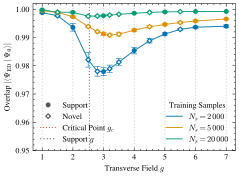

In [9]:
FIG_NAME = "tfim_4x4_data_scaling.pdf"

# local styling overrides
SIZE_SUPP   = 5.0
SIZE_NOV    = 3.3
LEGEND_GREY = "0.35"
YLIM        = (0.95, 1.002)
LINE_ALPHA  = 0.9

# errorbar styling (true "vanilla" errorbars)
ERR = dict(
    elinewidth=0.7,
    capsize=3,
    capthick=0.7,
    alpha=0.85,
)

# legend handles
h_sem_supp = Line2D([0], [0], linestyle="None", label="Support",
                    marker=STYLE_MARKER_BASE["support"]["marker"],
                    markersize=SIZE_SUPP, markerfacecolor=LEGEND_GREY,
                    markeredgecolor=LEGEND_GREY, markeredgewidth=0.0)

h_sem_nov  = Line2D([0], [0], linestyle="None", label="Novel",
                    marker=STYLE_MARKER_BASE["novel"]["marker"],
                    markersize=SIZE_NOV, markerfacecolor="white",
                    markeredgecolor=LEGEND_GREY,
                    markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"])

h_sem_crit = Line2D([0], [0], label=GC_LABEL, **STYLE_CRIT)
h_sem_guide= Line2D([0], [0], label=SUPPORT_LABEL_T, alpha=1.0, **STYLE_LEGEND)

# figure plotting
width  = SINGLE_COL_WIDTH
height = width * 0.75
fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

for i, item in enumerate(f1_data):
    color = SB_COLORBLIND[i % len(SB_COLORBLIND)]
    n_tex = f"{item['n_samples']:,}".replace(",", r"\,")

    # mean line
    ax.plot(item["df"]["h"], item["df"]["overlap"],
            color=color, label=rf"$N_s={n_tex}$",
            linestyle="-", linewidth=1.0, alpha=LINE_ALPHA,
            zorder=Z_DATA)

    has_err = ("overlap_err" in item["df"].columns)

    if has_err:
        # --- SUPPORT: draw bars+caps first (no markers), then markers on top ---
        ax.errorbar(item["supp"]["h"], item["supp"]["overlap"],
                    yerr=item["supp"]["overlap_err"],
                    fmt="none", ecolor=color, linestyle="None",
                    label="_nolegend_", zorder=Z_DATA + 1, **ERR)

        ax.plot(item["supp"]["h"], item["supp"]["overlap"],
                linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["support"]["marker"],
                markersize=SIZE_SUPP,
                color=color, markerfacecolor=color,
                markeredgewidth=0.0,
                zorder=Z_DATA + 2)

        # --- NOVEL: same strategy ---
        ax.errorbar(item["nov"]["h"], item["nov"]["overlap"],
                    yerr=item["nov"]["overlap_err"],
                    fmt="none", ecolor=color, linestyle="None",
                    label="_nolegend_", zorder=Z_DATA + 1, **ERR)

        ax.plot(item["nov"]["h"], item["nov"]["overlap"],
                linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["novel"]["marker"],
                markersize=SIZE_NOV,
                color=color, markerfacecolor="white",
                markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"],
                zorder=Z_DATA + 2)

    else:
        # fallback (no error columns)
        ax.plot(item["supp"]["h"], item["supp"]["overlap"], linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["support"]["marker"], markersize=SIZE_SUPP,
                color=color, markerfacecolor=color, markeredgewidth=0.0,
                zorder=Z_DATA + 2)

        ax.plot(item["nov"]["h"], item["nov"]["overlap"], linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["novel"]["marker"], markersize=SIZE_NOV,
                color=color, markerfacecolor="white",
                markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"],
                zorder=Z_DATA + 2)

draw_backdrop(ax, f1_support_g, GC_VAL_4X4)

ax.set_xlabel(r"Transverse Field $g$")
ax.set_ylabel(r"Overlap $\left|\left\langle \Psi_\mathrm{ED}\mid \Psi_{\mathrm{θ}}\right\rangle\right|$")
if YLIM:
    ax.set_ylim(YLIM)

ax.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

# robust legend creation
leg_samples = ax.legend(loc="lower right", title=r"Training Samples", frameon=False)
leg_semantic = ax.legend(handles=[h_sem_supp, h_sem_nov, h_sem_crit, h_sem_guide],
                         loc="lower left", frameon=False)
ax.add_artist(leg_samples)

ax.grid(False)
fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight")
    print(f"Saved: {FIG_NAME}")
plt.show()


Saved: tfim_4x4_data_scaling.pdf


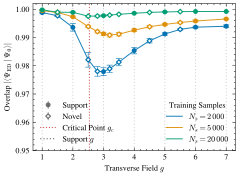

In [11]:
FIG_NAME = "tfim_4x4_data_scaling.pdf"

# local styling overrides
SIZE_SUPP   = 5.0
SIZE_NOV    = 3.3
LEGEND_GREY = "0.35"
YLIM        = (0.95, 1.002)
LINE_ALPHA  = 0.9

# errorbar styling (true "vanilla" errorbars)
ERR = dict(
    elinewidth=0.7,
    capsize=3.0,
    capthick=0.7,
    alpha=0.85,
)

# --- legend handles (semantic, left) with caps ---
# Use ErrorbarContainer so the legend icon actually includes bars + caps.
h_sem_supp = ax.errorbar([], [], yerr=[0.006], fmt=STYLE_MARKER_BASE["support"]["marker"],
                         markersize=SIZE_SUPP,
                         color=LEGEND_GREY, markerfacecolor=LEGEND_GREY,
                         markeredgecolor=LEGEND_GREY, markeredgewidth=0.0,
                         linestyle="None", label="Support", **ERR)

h_sem_nov  = ax.errorbar([], [], yerr=[0.006], fmt=STYLE_MARKER_BASE["novel"]["marker"],
                         markersize=SIZE_NOV,
                         color=LEGEND_GREY, markerfacecolor="white",
                         markeredgecolor=LEGEND_GREY,
                         markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"],
                         linestyle="None", label="Novel", **ERR)

h_sem_crit  = Line2D([0], [0], label=GC_LABEL, **STYLE_CRIT)
h_sem_guide = Line2D([0], [0], label=SUPPORT_LABEL_T, alpha=1.0, **STYLE_LEGEND)

# figure plotting
width  = SINGLE_COL_WIDTH
height = width * 0.75
fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

for i, item in enumerate(f1_data):
    color = SB_COLORBLIND[i % len(SB_COLORBLIND)]
    n_tex = f"{item['n_samples']:,}".replace(",", r"\,")

    # mean line
    ax.plot(item["df"]["h"], item["df"]["overlap"],
            color=color, label=rf"$N_s={n_tex}$",
            linestyle="-", linewidth=1.0, alpha=LINE_ALPHA,
            zorder=Z_DATA)

    has_err = ("overlap_err" in item["df"].columns)

    if has_err:
        # bars+caps first (no markers)
        ax.errorbar(item["supp"]["h"], item["supp"]["overlap"],
                    yerr=item["supp"]["overlap_err"],
                    fmt="none", ecolor=color, linestyle="None",
                    label="_nolegend_", zorder=Z_DATA + 1, **ERR)

        ax.plot(item["supp"]["h"], item["supp"]["overlap"],
                linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["support"]["marker"],
                markersize=SIZE_SUPP,
                color=color, markerfacecolor=color,
                markeredgewidth=0.0,
                zorder=Z_DATA + 2)

        ax.errorbar(item["nov"]["h"], item["nov"]["overlap"],
                    yerr=item["nov"]["overlap_err"],
                    fmt="none", ecolor=color, linestyle="None",
                    label="_nolegend_", zorder=Z_DATA + 1, **ERR)

        ax.plot(item["nov"]["h"], item["nov"]["overlap"],
                linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["novel"]["marker"],
                markersize=SIZE_NOV,
                color=color, markerfacecolor="white",
                markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"],
                zorder=Z_DATA + 2)

    else:
        ax.plot(item["supp"]["h"], item["supp"]["overlap"], linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["support"]["marker"], markersize=SIZE_SUPP,
                color=color, markerfacecolor=color, markeredgewidth=0.0,
                zorder=Z_DATA + 2)

        ax.plot(item["nov"]["h"], item["nov"]["overlap"], linestyle="None", label="_nolegend_",
                marker=STYLE_MARKER_BASE["novel"]["marker"], markersize=SIZE_NOV,
                color=color, markerfacecolor="white",
                markeredgewidth=STYLE_MARKER_BASE["novel"]["edge_w"],
                zorder=Z_DATA + 2)

draw_backdrop(ax, f1_support_g, GC_VAL_4X4)

ax.set_xlabel(r"Transverse Field $g$")
ax.set_ylabel(r"Overlap $\left|\left\langle \Psi_\mathrm{ED}\mid \Psi_{\mathrm{θ}}\right\rangle\right|$")
if YLIM:
    ax.set_ylim(YLIM)

ax.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

# robust legend creation
leg_samples = ax.legend(loc="lower right", title=r"Training Samples", frameon=False)

leg_semantic = ax.legend(handles=[h_sem_supp, h_sem_nov, h_sem_crit, h_sem_guide],
                         loc="lower left", frameon=False)
ax.add_artist(leg_samples)

ax.grid(False)
fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight")
    print(f"Saved: {FIG_NAME}")
plt.show()
